In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.layers import Conv2D, Dense, BatchNormalization, Activation, Dropout, MaxPooling2D, Flatten
from keras.optimizers import Adam, RMSprop, SGD
from keras import regularizers
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint, CSVLogger, TensorBoard, EarlyStopping, ReduceLROnPlateau
import datetime
import matplotlib.pyplot as plt
from keras.utils import plot_model

In [5]:
import os
import pandas as pd
from PIL import Image

train_dir = '/content/drive/MyDrive/Colab Notebooks/data filtered/data/train'
test_dir = '/content/drive/MyDrive/Colab Notebooks/data filtered/data/test'

row, col = 48, 48
classes = 6

def count_exp(path, set_):
    dict_ = {}
    for expression in os.listdir(path):
        dir_ = os.path.join(path, expression)
        count = 0

        for filename in os.listdir(dir_):
            img_path = os.path.join(dir_, filename)

            # Convert the image to grayscale
            img = Image.open(img_path).convert('L')

            # Update the count
            count += 1

        dict_[expression] = count

    df = pd.DataFrame(dict_, index=[set_])
    return df

train_count = count_exp(train_dir, 'train')
test_count = count_exp(test_dir, 'test')

print("Train Count:")
print(train_count)

print("\nTest Count:")
print(test_count)


Train Count:
       neutral  angry  fear  happy   sad  surprise
train     4370   3228  2218   7632  4409      2840

Test Count:
      angry  fear  happy  neutral  sad  surprise
test    684   597   1145      877  792       748


In [6]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   zoom_range=0.3,
                                   horizontal_flip=True)

training_set = train_datagen.flow_from_directory(train_dir,
                                                batch_size=64,
                                                target_size=(48,48),
                                                shuffle=True,
                                                color_mode='grayscale',
                                                class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1./255)
test_set = test_datagen.flow_from_directory(test_dir,
                                                batch_size=64,
                                                target_size=(48,48),
                                                shuffle=True,
                                                color_mode='grayscale',
                                                class_mode='categorical')

Found 24697 images belonging to 6 classes.
Found 4843 images belonging to 6 classes.


In [7]:
training_set.class_indices

{'angry': 0, 'fear': 1, 'happy': 2, 'neutral': 3, 'sad': 4, 'surprise': 5}

In [8]:
def get_model(input_size, classes=6):
    # Initializing the CNN
    model = Sequential()

    model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=input_size))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2, 2))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)))
    model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(classes, activation='softmax'))

    # Using the legacy optimizer to avoid the warning
    optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.0001, decay=1e-6)

    # Compiling the model
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model



In [9]:
fernet = get_model((row,col,1), classes)
fernet.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        18496     
                                                                 
 batch_normalization (Batch  (None, 48, 48, 64)        256       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 128)       7

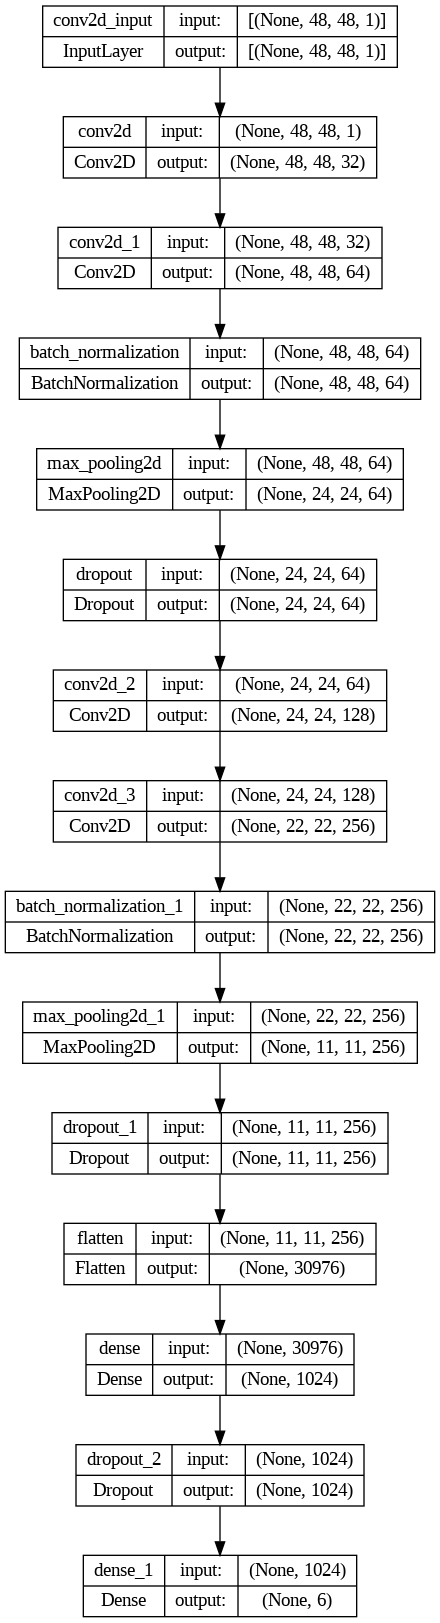

In [10]:
plot_model(fernet, to_file='fernet.png', show_shapes=True, show_layer_names=True)

In [11]:
chk_path = 'ferNet.h5'
log_dir = "checkpoint/logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

checkpoint = ModelCheckpoint(filepath=chk_path,
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             moniter='val_loss')

earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=3,
                          verbose=1,
                          restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=6,
                              verbose=1,
                              min_delta=0.0001)


tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
csv_logger = CSVLogger('training.log')

callbacks = [checkpoint, reduce_lr, csv_logger]

In [12]:
steps_per_epoch = training_set.n // training_set.batch_size
validation_steps = test_set.n // test_set.batch_size

hist = fernet.fit(x=training_set,
                 validation_data=test_set,
                 epochs=50,
                 callbacks=callbacks,
                 steps_per_epoch=steps_per_epoch,
                 validation_steps=validation_steps)

Epoch 1/50
385/385 [==============================] - ETA: 0s - loss: 4.1406 - accuracy: 0.3471
Epoch 1: val_loss improved from inf to 4.01449, saving model to ferNet.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


385/385 [==============================] - 128s 303ms/step - loss: 4.1406 - accuracy: 0.3471 - val_loss: 4.0145 - val_accuracy: 0.3427 - lr: 1.0000e-04
Epoch 2/50
385/385 [==============================] - ETA: 0s - loss: 3.3755 - accuracy: 0.4186
Epoch 2: val_loss improved from 4.01449 to 3.16295, saving model to ferNet.h5
385/385 [==============================] - 121s 313ms/step - loss: 3.3755 - accuracy: 0.4186 - val_loss: 3.1630 - val_accuracy: 0.4571 - lr: 1.0000e-04
Epoch 3/50
385/385 [==============================] - ETA: 0s - loss: 2.9100 - accuracy: 0.4540
Epoch 3: val_loss improved from 3.16295 to 2.74613, saving model to ferNet.h5
385/385 [==============================] - 117s 303ms/step - loss: 2.9100 - accuracy: 0.4540 - val_loss: 2.7461 - val_accuracy: 0.4748 - lr: 1.0000e-04
Epoch 4/50
385/385 [==============================] - ETA: 0s - loss: 2.5062 - accuracy: 0.4922
Epoch 4: val_loss improved from 2.74613 to 2.46154, saving model to ferNet.h5
385/385 [=============

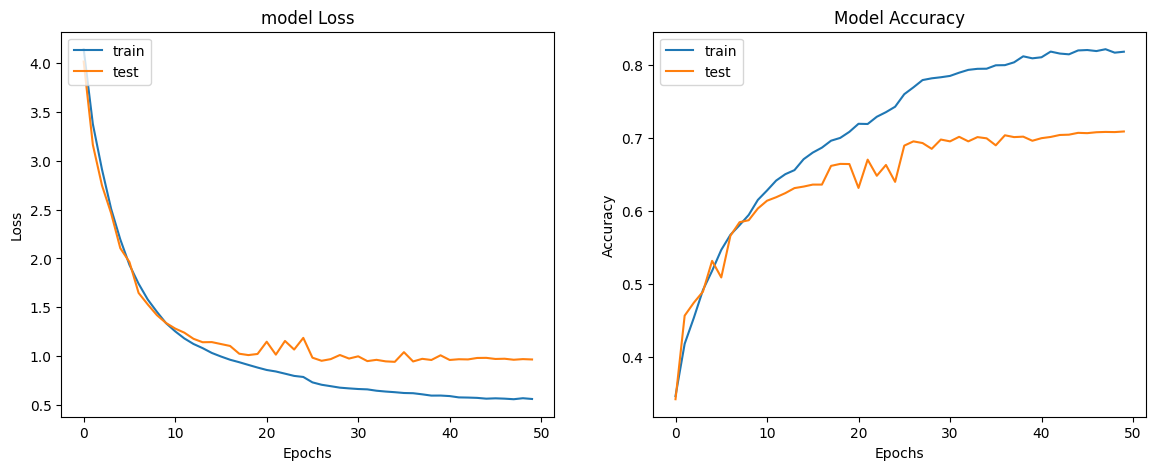

In [13]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,2)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(1,2,1)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [14]:
train_loss, train_accu = fernet.evaluate(training_set)
test_loss, test_accu = fernet.evaluate(test_set)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu*100, test_accu*100))

76/76 [==============================] - 9s 124ms/step - loss: 0.9685 - accuracy: 0.7080
final train accuracy = 87.18 , validation accuracy = 70.80


In [17]:
model_json = fernet.to_json()
with open("/content/drive/MyDrive/Colab Notebooks/emotion_model_fernet.json", "w") as json_file:
    json_file.write(model_json)

fernet.save_weights('/content/drive/MyDrive/Colab Notebooks/emotion_model_fernet.h5')